Computing PSD:   0%|          | 0/60 [00:00<?, ?subject-session/s]

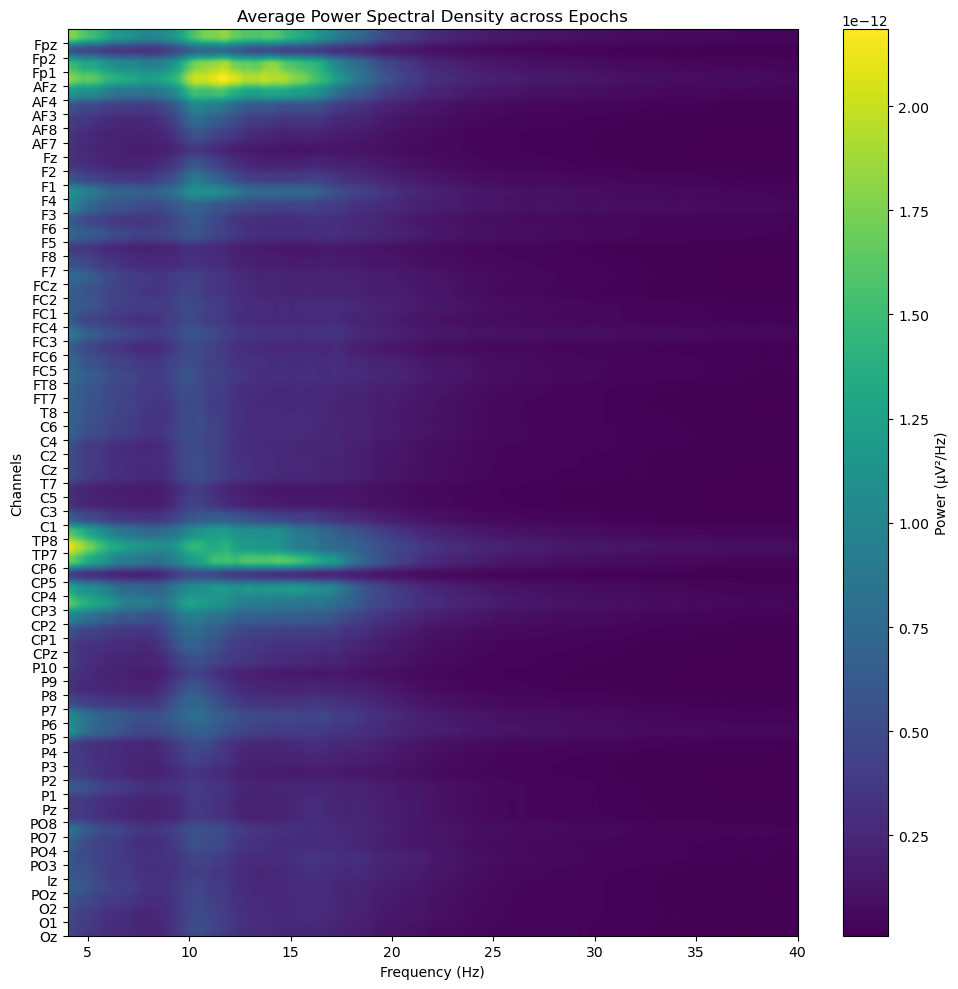

Computing PSD:   0%|          | 0/19 [00:00<?, ?subject-session/s]

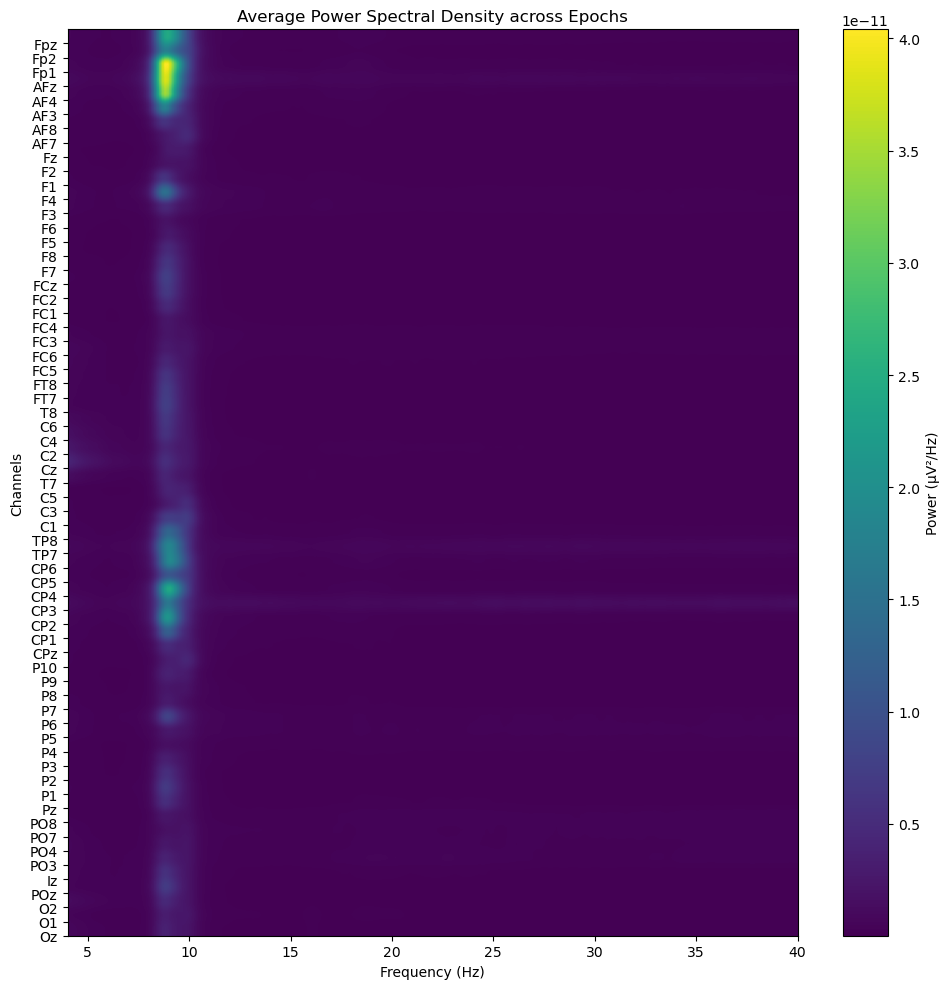

Computing PSD: 100%|██████████| 19/19 [00:01<00:00, 10.42subject-session/s]


In [ ]:
import mne
import numpy as np
import os
from joblib import cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

import utils.config as config
from utils.config import DATASETS, EEG_SETTINGS
from utils.file_io import save_psd_data, load_epochs
from utils.helpers import generate_metadata_df, remap_events_to_original

# Specify the subfolder for the epochs path
EPOCHS_SUBFOLDER = "ica_cleaned"

def save_psd_data(psds, freqs, channels, metadata_df, output_dir, fname_prefix):
    """
    Save PSD data and metadata explicitly to the given directory.

    Parameters:
        psds (ndarray): PSD data (epochs × channels × frequencies).
        freqs (ndarray): Frequency values.
        channels (list[str]): Channel names.
        metadata_df (pd.DataFrame): Metadata DataFrame.
        output_dir (str): Path to the directory to save files.
        fname_prefix (str): Filename prefix for saved files (without extension).
    """

    os.makedirs(output_dir, exist_ok=True)

    np.savez_compressed(
        os.path.join(output_dir, f"{fname_prefix}_psd.npz"),
        psd=psds,
        freqs=freqs,
        channels=channels
    )

    metadata_df.to_csv(
        os.path.join(output_dir, f"{fname_prefix}_metadata.csv"),
        index=False
    )

def compute_psd(epochs, 
                fmin = EEG_SETTINGS["PSD_FMIN"], 
                fmax = EEG_SETTINGS["PSD_FMAX"], 
                n_fft = EEG_SETTINGS["PSD_N_FFT"],
                n_per_seg = EEG_SETTINGS["PSD_N_PER_SEG"], 
                n_overlap = EEG_SETTINGS["PSD_N_OVERLAP"], 
                window = EEG_SETTINGS["PSD_WINDOW"], 
                remove_dc = EEG_SETTINGS["PSD_REMOVE_DC"]):
    """
    Compute PSD using Welch's method for given epochs, focusing only on EEG channels.

    Parameters:
        epochs (mne.Epochs): EEG epochs data
        fmin, fmax (float): frequency range for PSD
        n_fft, n_overlap (int): FFT parameters matching Rayleigh frequency
        window (str): window taper to use

    Returns:
        tuple: PSD array (epochs x channels x frequencies), frequency array
    """
    n_jobs = cpu_count()  # Determine the number of jobs based on CPU cores


    data = epochs.get_data()
    sfreq = epochs.info['sfreq']

    psd, freqs = mne.time_frequency.psd_array_welch(
        data,
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        n_fft=n_fft,
        n_per_seg=n_per_seg,
        n_overlap=n_overlap,
        window=window,
        average='median',
        output='power',
        n_jobs=n_jobs,
        remove_dc=remove_dc,
        verbose=False  
    )

    return psd, freqs


def compute_psd_data(dataset_name):
    """
    Compute the PSD data for all subjects in a given dataset, showing a progress bar.

    Parameters:
        dataset_name (str): Identifier for dataset configuration.
    """
    dataset_config = DATASETS[dataset_name]

    # Create a clearly structured iteration list
    subject_session_pairs = [
        (subject, session)
        for subject in dataset_config.subjects
        for session in dataset_config.sessions
    ]

    for subject, session in tqdm(subject_session_pairs, desc="Computing PSD", unit="subject-session"):
        epochs_path = os.path.join(dataset_config.path_epochs, EPOCHS_SUBFOLDER)
        epochs = load_epochs(epochs_path, subject, session, verbose=False)

        if epochs is None:
            continue

        if dataset_name == "jin2019":
            epochs = remap_events_to_original(epochs)

        # Pick only EEG channels
        epochs = epochs.pick_types(eeg=True, verbose=False)

        #sorting the channel positions by y coordinate
        channel_positions = config.channel_positions
        channels = sorted(epochs.ch_names, key=lambda x: channel_positions[x][1])


        # Compute PSD using different parameters and saving data with uniqe file name
        
        psd, freqs = compute_psd(epochs)
        psd_avg = np.mean(psd, axis=0)
        psd_avg_db = 10 * np.log10(psd_avg + 1e-12)  # add epsilon to avoid log(0)


        plt.figure(figsize=(10, 10))
        im = plt.imshow(psd_avg, aspect='auto', origin='lower',
                        extent=[freqs[0], freqs[-1], 0, len(channels)],
                        cmap='viridis')  # or 'magma', 'plasma', etc.

        plt.colorbar(im, label='Power (µV²/Hz)')
        plt.yticks(ticks=np.arange(len(channels)), labels=channels)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Channels')
        plt.title('Average Power Spectral Density across Epochs')
        plt.tight_layout()
        plt.show()



def main():
    dataset_names = ["jin2019", "braboszcz2017"]  # or set dynamically
    for dataset_name in dataset_names:
        compute_psd_data(dataset_name)
    # compute_spectrograms()  # Implement later

if __name__ == "__main__":
    main()

Computing PSD:   0%|          | 0/60 [00:00<?, ?subject-session/s]

(423, 64, 73)
(423, 64, 289)


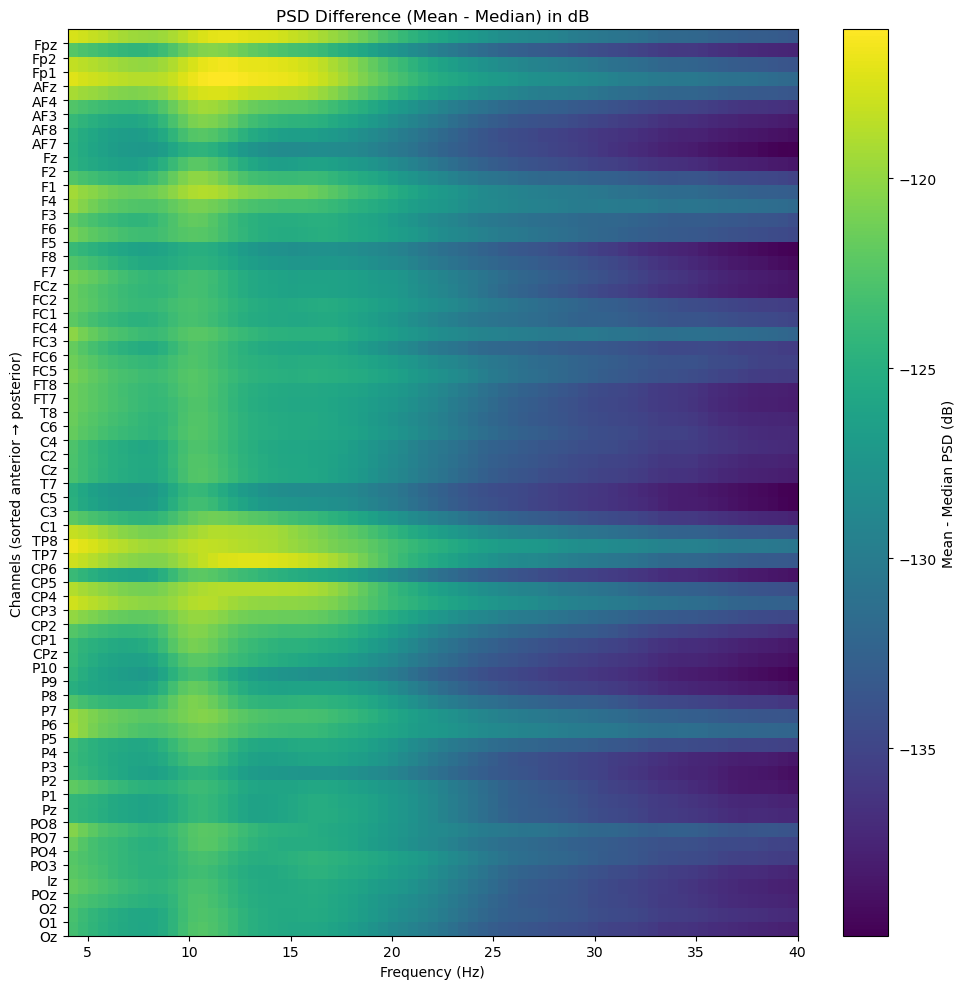

Computing PSD:   0%|          | 0/19 [00:00<?, ?subject-session/s]

(227, 64, 73)
(227, 64, 289)


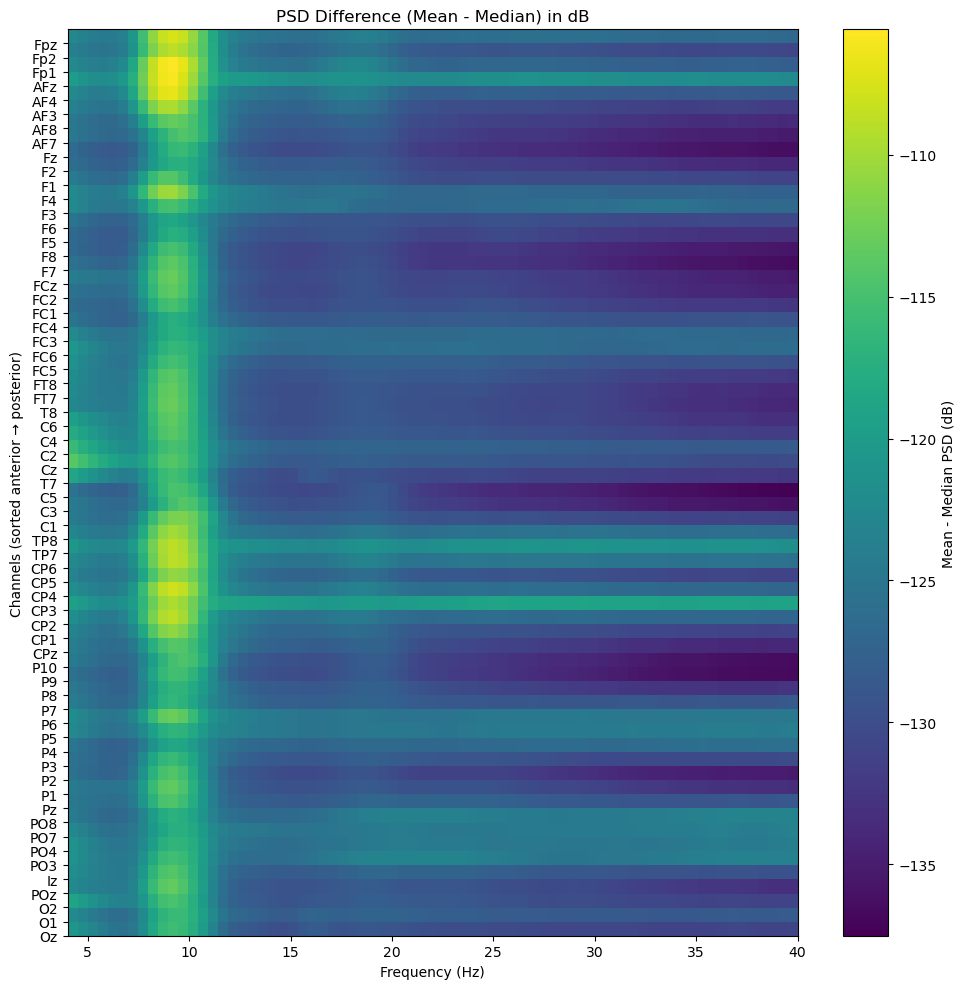

Computing PSD: 100%|██████████| 19/19 [00:01<00:00, 13.30subject-session/s]


In [17]:
import mne
import numpy as np
import os
from joblib import cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

import utils.config as config
from utils.config import DATASETS, EEG_SETTINGS
from utils.file_io import save_psd_data, load_epochs
from utils.helpers import generate_metadata_df, remap_events_to_original

# Specify the subfolder for the epochs path
EPOCHS_SUBFOLDER = "ica_cleaned"

def save_psd_data(psds, freqs, channels, metadata_df, output_dir, fname_prefix):
    """
    Save PSD data and metadata explicitly to the given directory.

    Parameters:
        psds (ndarray): PSD data (epochs × channels × frequencies).
        freqs (ndarray): Frequency values.
        channels (list[str]): Channel names.
        metadata_df (pd.DataFrame): Metadata DataFrame.
        output_dir (str): Path to the directory to save files.
        fname_prefix (str): Filename prefix for saved files (without extension).
    """

    os.makedirs(output_dir, exist_ok=True)

    np.savez_compressed(
        os.path.join(output_dir, f"{fname_prefix}_psd.npz"),
        psd=psds,
        freqs=freqs,
        channels=channels
    )

    metadata_df.to_csv(
        os.path.join(output_dir, f"{fname_prefix}_metadata.csv"),
        index=False
    )

def compute_psd(epochs, 
                fmin = EEG_SETTINGS["PSD_FMIN"], 
                fmax = EEG_SETTINGS["PSD_FMAX"], 
                n_fft = EEG_SETTINGS["PSD_N_FFT"],
                n_per_seg = EEG_SETTINGS["PSD_N_PER_SEG"], 
                n_overlap = EEG_SETTINGS["PSD_N_OVERLAP"], 
                window = EEG_SETTINGS["PSD_WINDOW"],
                average = EEG_SETTINGS["PSD_AVERAGE_METHOD"], 
                remove_dc = EEG_SETTINGS["PSD_REMOVE_DC"]):
    """
    Compute PSD using Welch's method for given epochs, focusing only on EEG channels.

    Parameters:
        epochs (mne.Epochs): EEG epochs data
        fmin, fmax (float): frequency range for PSD
        n_fft, n_overlap (int): FFT parameters matching Rayleigh frequency
        window (str): window taper to use

    Returns:
        tuple: PSD array (epochs x channels x frequencies), frequency array
    """
    n_jobs = cpu_count()  # Determine the number of jobs based on CPU cores


    data = epochs.get_data()
    sfreq = epochs.info['sfreq']

    psd, freqs = mne.time_frequency.psd_array_welch(
        data,
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        n_fft=n_fft,
        n_per_seg=n_per_seg,
        n_overlap=n_overlap,
        window=window,
        average=average,
        output='power',
        n_jobs=n_jobs,
        remove_dc=remove_dc,
        verbose=False  
    )

    return psd, freqs


def compute_psd_data(dataset_name):
    """
    Compute the PSD data for all subjects in a given dataset, showing a progress bar.

    Parameters:
        dataset_name (str): Identifier for dataset configuration.
    """
    dataset_config = DATASETS[dataset_name]

    # Create a clearly structured iteration list
    subject_session_pairs = [
        (subject, session)
        for subject in dataset_config.subjects
        for session in dataset_config.sessions
    ]

    for subject, session in tqdm(subject_session_pairs, desc="Computing PSD", unit="subject-session"):
        epochs_path = os.path.join(dataset_config.path_epochs, EPOCHS_SUBFOLDER)
        epochs = load_epochs(epochs_path, subject, session, verbose=False)

        if epochs is None:
            continue

        if dataset_name == "jin2019":
            epochs = remap_events_to_original(epochs)

        # Ensure EEG-only channels are selected
        epochs = epochs.pick_types(eeg=True, verbose=False)

        # Sort channel names by y-position (for nicer plotting top-to-bottom)
        channel_positions = config.channel_positions
        channels = sorted(epochs.ch_names, key=lambda x: channel_positions[x][1])

        # Compute PSDs with mean and median
        psd_mean, freqs = compute_psd(epochs, n_fft=256, n_per_seg=128, n_overlap=64)
        print(psd_mean.shape)
        psd_median, _ = compute_psd(epochs)
        print(psd_median.shape)

        # Average across epochs (now shape is: channels x freqs)
        psd_mean_avg = np.mean(psd_mean, axis=0)
        psd_median_avg = np.mean(psd_median, axis=0)

        # Convert to dB scale
        psd_mean_db = 10 * np.log10(psd_mean_avg + 1e-20)
        psd_median_db = 10 * np.log10(psd_median_avg + 1e-20)

        # Difference in dB
        #psd_diff_db = psd_mean_db - psd_median_db

        # Plot the difference as a heatmap (spectrogram style)
        plt.figure(figsize=(10, 10))
        im = plt.imshow(psd_mean_db, aspect='auto', origin='lower',
                        extent=[freqs[0], freqs[-1], 0, len(channels)],
                        cmap='viridis')  # or 'magma', 'plasma', etc.

        plt.colorbar(im, label='Mean - Median PSD (dB)')
        plt.yticks(ticks=np.arange(len(channels)), labels=channels)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Channels (sorted anterior → posterior)')
        plt.title('PSD Difference (Mean - Median) in dB')
        plt.tight_layout()
        plt.show()



def main():
    dataset_names = ["jin2019", "braboszcz2017"]  # or set dynamically
    for dataset_name in dataset_names:
        compute_psd_data(dataset_name)
    # compute_spectrograms()  # Implement later

if __name__ == "__main__":
    main()

Computing PSD:   0%|          | 0/60 [00:00<?, ?subject-session/s]

(423, 64, 145)
(423, 64, 289)


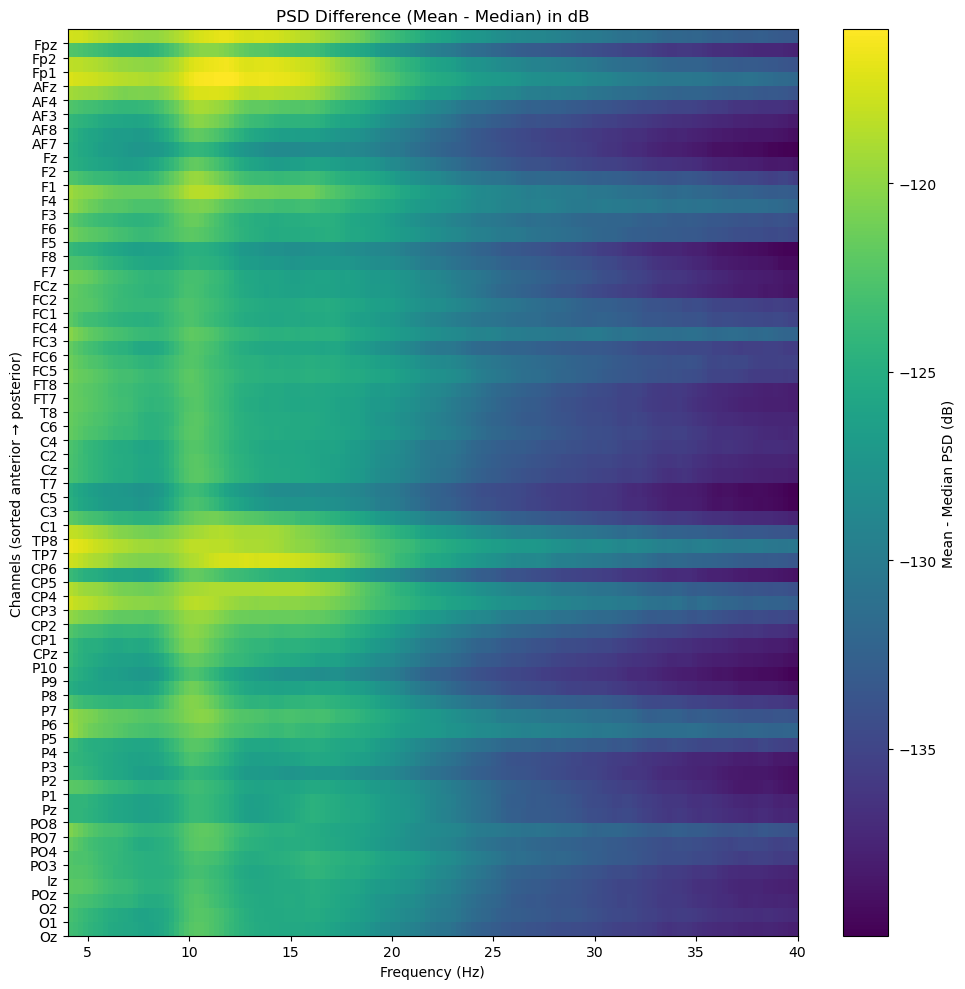

Computing PSD:   0%|          | 0/19 [00:00<?, ?subject-session/s]

(227, 64, 145)
(227, 64, 289)


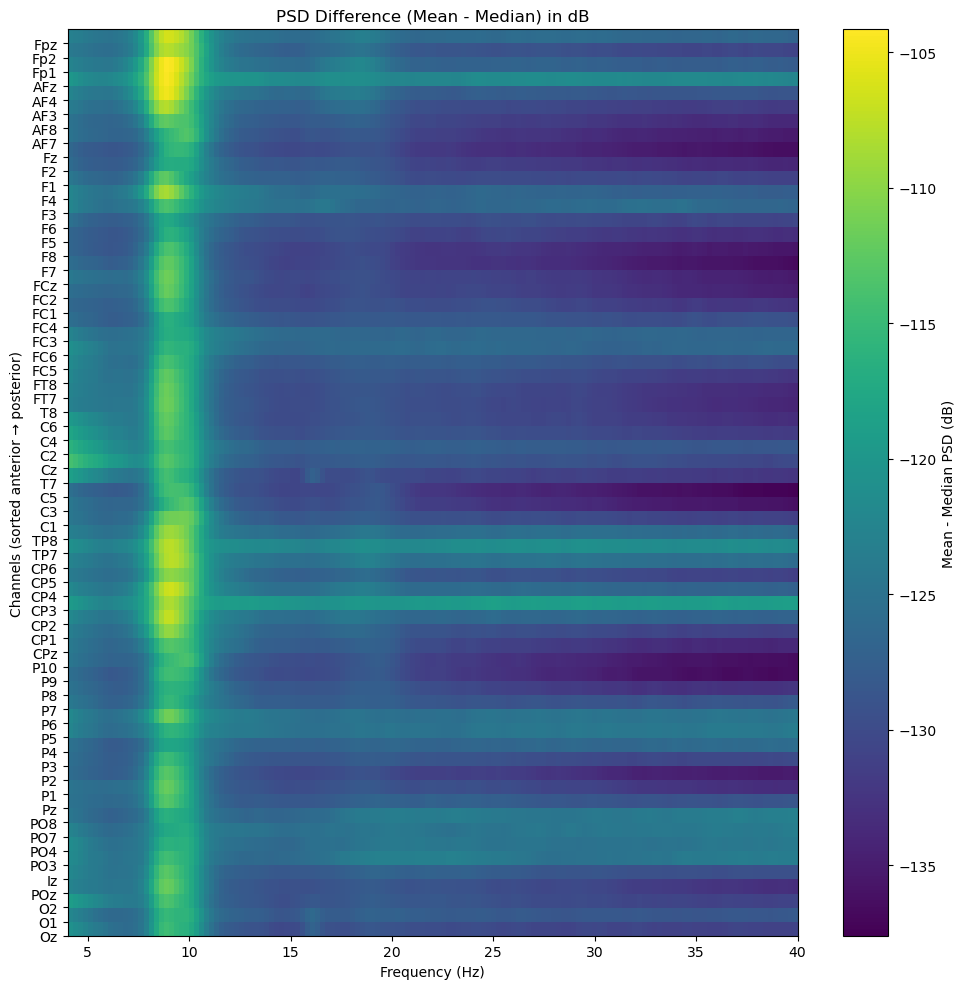

Computing PSD: 100%|██████████| 19/19 [00:01<00:00, 11.91subject-session/s]


In [18]:
import mne
import numpy as np
import os
from joblib import cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt

import utils.config as config
from utils.config import DATASETS, EEG_SETTINGS
from utils.file_io import save_psd_data, load_epochs
from utils.helpers import generate_metadata_df, remap_events_to_original

# Specify the subfolder for the epochs path
EPOCHS_SUBFOLDER = "ica_cleaned"

def save_psd_data(psds, freqs, channels, metadata_df, output_dir, fname_prefix):
    """
    Save PSD data and metadata explicitly to the given directory.

    Parameters:
        psds (ndarray): PSD data (epochs × channels × frequencies).
        freqs (ndarray): Frequency values.
        channels (list[str]): Channel names.
        metadata_df (pd.DataFrame): Metadata DataFrame.
        output_dir (str): Path to the directory to save files.
        fname_prefix (str): Filename prefix for saved files (without extension).
    """

    os.makedirs(output_dir, exist_ok=True)

    np.savez_compressed(
        os.path.join(output_dir, f"{fname_prefix}_psd.npz"),
        psd=psds,
        freqs=freqs,
        channels=channels
    )

    metadata_df.to_csv(
        os.path.join(output_dir, f"{fname_prefix}_metadata.csv"),
        index=False
    )

def compute_psd(epochs, 
                fmin = EEG_SETTINGS["PSD_FMIN"], 
                fmax = EEG_SETTINGS["PSD_FMAX"], 
                n_fft = EEG_SETTINGS["PSD_N_FFT"],
                n_per_seg = EEG_SETTINGS["PSD_N_PER_SEG"], 
                n_overlap = EEG_SETTINGS["PSD_N_OVERLAP"], 
                window = EEG_SETTINGS["PSD_WINDOW"],
                average = EEG_SETTINGS["PSD_AVERAGE_METHOD"], 
                remove_dc = EEG_SETTINGS["PSD_REMOVE_DC"]):
    """
    Compute PSD using Welch's method for given epochs, focusing only on EEG channels.

    Parameters:
        epochs (mne.Epochs): EEG epochs data
        fmin, fmax (float): frequency range for PSD
        n_fft, n_overlap (int): FFT parameters matching Rayleigh frequency
        window (str): window taper to use

    Returns:
        tuple: PSD array (epochs x channels x frequencies), frequency array
    """
    n_jobs = cpu_count()  # Determine the number of jobs based on CPU cores


    data = epochs.get_data()
    sfreq = epochs.info['sfreq']

    psd, freqs = mne.time_frequency.psd_array_welch(
        data,
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        n_fft=n_fft,
        n_per_seg=n_per_seg,
        n_overlap=n_overlap,
        window=window,
        average=average,
        output='power',
        n_jobs=n_jobs,
        remove_dc=remove_dc,
        verbose=False  
    )

    return psd, freqs


def compute_psd_data(dataset_name):
    """
    Compute the PSD data for all subjects in a given dataset, showing a progress bar.

    Parameters:
        dataset_name (str): Identifier for dataset configuration.
    """
    dataset_config = DATASETS[dataset_name]

    # Create a clearly structured iteration list
    subject_session_pairs = [
        (subject, session)
        for subject in dataset_config.subjects
        for session in dataset_config.sessions
    ]

    for subject, session in tqdm(subject_session_pairs, desc="Computing PSD", unit="subject-session"):
        epochs_path = os.path.join(dataset_config.path_epochs, EPOCHS_SUBFOLDER)
        epochs = load_epochs(epochs_path, subject, session, verbose=False)

        if epochs is None:
            continue

        if dataset_name == "jin2019":
            epochs = remap_events_to_original(epochs)

        # Ensure EEG-only channels are selected
        epochs = epochs.pick_types(eeg=True, verbose=False)

        # Sort channel names by y-position (for nicer plotting top-to-bottom)
        channel_positions = config.channel_positions
        channels = sorted(epochs.ch_names, key=lambda x: channel_positions[x][1])

        # Compute PSDs with mean and median
        psd_mean, freqs = compute_psd(epochs, n_fft=512, n_per_seg=256, n_overlap=128)
        print(psd_mean.shape)
        psd_median, _ = compute_psd(epochs)
        print(psd_median.shape)

        # Average across epochs (now shape is: channels x freqs)
        psd_mean_avg = np.mean(psd_mean, axis=0)
        psd_median_avg = np.mean(psd_median, axis=0)

        # Convert to dB scale
        psd_mean_db = 10 * np.log10(psd_mean_avg + 1e-20)
        psd_median_db = 10 * np.log10(psd_median_avg + 1e-20)

        # Difference in dB
        #psd_diff_db = psd_mean_db - psd_median_db

        # Plot the difference as a heatmap (spectrogram style)
        plt.figure(figsize=(10, 10))
        im = plt.imshow(psd_mean_db, aspect='auto', origin='lower',
                        extent=[freqs[0], freqs[-1], 0, len(channels)],
                        cmap='viridis')  # or 'magma', 'plasma', etc.

        plt.colorbar(im, label='Mean - Median PSD (dB)')
        plt.yticks(ticks=np.arange(len(channels)), labels=channels)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Channels (sorted anterior → posterior)')
        plt.title('PSD Difference (Mean - Median) in dB')
        plt.tight_layout()
        plt.show()



def main():
    dataset_names = ["jin2019", "braboszcz2017"]  # or set dynamically
    for dataset_name in dataset_names:
        compute_psd_data(dataset_name)
    # compute_spectrograms()  # Implement later

if __name__ == "__main__":
    main()